In [1]:
from __future__ import print_function, division
import os, bz2, json, time, sys, csv
from datetime import timedelta, datetime

import math
import collections
import numpy as np
import pandas as pd
import matplotlib as mpl
import scipy.stats as stats

from matplotlib import pyplot as plt
from tqdm import tqdm

from util_read import engage_read, read_vids, engage_tweets_read, merge_engage_tweets, engage_metadata, compute_period_daily

In [2]:
file_vids_filter_all = "/home/users/u6314203/pyProject/hip-popularity/data/engage16/filtered/vids_filter_all.csv" 
engage_dataset_base = "/localdata/u6314203/dataset_engage16/tweeted_videos" 
tweets_dataset_base = "/localdata/u6314203/dataset_tweets_engage/dataset_tweets_fixTZ"

# file_vids_filter_all = "C:/Users/u6314203/pyProjects/hip-popularity/data/engage16/filtered/vids_filter_all.csv"
# engage_dataset_base = "G:/MLCV dataset/engagement'16/tweeted_videos"
# tweets_dataset_base = "G:/MLCV dataset/engagement'16/tweets_dataset_fixTZ"

categories_eligible = ["autos", "comedy","education","entertainment", \
                       "film","gaming","howto","music",\
                       "news","people","science","sports",\
                       "travel"]

In [3]:
# vids from all category
vids_filter_all = read_vids(file_vids_filter_all)

merged_dataset = dict()
# engage_metadata = dict() 
for category in categories_eligible[1:2]:
    engage_dataset = engage_read(engage_dataset_base, category)
    tweets_dataset = engage_tweets_read(tweets_dataset_base, category)
    
    curr_merged = merge_engage_tweets(engage_dataset, tweets_dataset)
    merged_dataset.update(curr_merged)
    
print(f"Total size: {len(merged_dataset)}")

Vids(filtered) in each category:
autos:25712; comedy:31741; education:41191; entertainment:180128; film:43101; gaming:222236; howto:61027; music:118094; news:38249; people:222658; science:32278; sports:39649; travel:13112
Engage comedy size: 31519
Tweets comedy size: 31678
Merged size: 31456
Total size: 31456


In [4]:
timepoint = 90
pearsonr_vals = []
vids = []
for k, vals in merged_dataset.items():
    series_views = vals["viewCounts"][timepoint:]
    series_tweets = vals["tweets"][timepoint:]
    r, p = stats.pearsonr(series_views, series_tweets)
    pearsonr_vals.append([r,p,np.mean(series_views),np.mean(series_tweets)])
    vids.append(k)

df_pearsonr = pd.DataFrame(pearsonr_vals, columns=["r", "p", "daily views", "daily tweets"], index=vids)
df_pearsonr = df_pearsonr[[not x for x in np.isnan(df_pearsonr["r"])]]
pd.DataFrame.describe(df_pearsonr)

/home/users/u6314203/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


,r,p,daily views,daily tweets
count,13923.000000,1.392300e+04,13923.000000,13923.000000
mean,0.095538,3.819990e-01,737.247059,0.062794
std,0.152413,3.314882e-01,3149.594596,0.464510
min,-0.182968,2.686726e-223,2.159574,0.004219
25%,-0.005877,3.393569e-02,26.272233,0.005236
50%,0.056836,3.410854e-01,102.092308,0.010989
75%,0.149821,6.768821e-01,435.854452,0.033149
max,0.996776,1.000000e+00,189785.009756,40.184466


Text(0, 0.5, 'pearson r value')

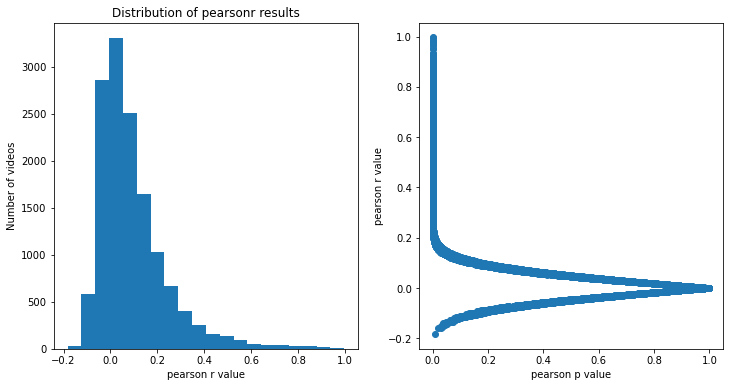

In [5]:
fig = plt.figure(figsize=(12, 6))

ax = fig.add_subplot(1,2,1)
n, bins, patches = ax.hist(df_pearsonr["r"], bins=20)
ax.set_title(f"Distribution of pearsonr results")
ax.set_xlabel("pearson r value")
ax.set_ylabel("Number of videos")

ax = fig.add_subplot(1,2,2)
ax.scatter(df_pearsonr["p"], df_pearsonr["r"])
ax.set_xlabel("pearson p value")
ax.set_ylabel("pearson r value")

In [6]:
df_filter = df_pearsonr[df_pearsonr["p"]<=0.05]

pd.DataFrame.describe(df_filter)

,r,p,daily views,daily tweets
count,3796.000000,3.796000e+03,3796.000000,3796.000000
mean,0.286273,8.266623e-03,1282.297922,0.146957
std,0.161185,1.303531e-02,4437.056892,0.572308
min,-0.182968,2.686726e-223,2.424731,0.004255
25%,0.176524,8.272344e-07,47.259653,0.010471
50%,0.234324,8.283049e-04,237.208164,0.032086
75%,0.338021,1.170916e-02,1067.578347,0.110059
max,0.996776,4.997525e-02,189785.009756,22.878788


Text(0, 0.5, 'pearson r value')

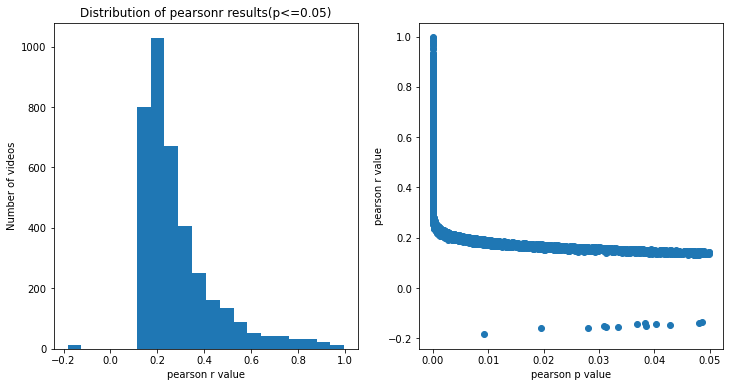

In [7]:
fig = plt.figure(figsize=(12, 6))

ax = fig.add_subplot(1,2,1)
n, bins, patches = ax.hist(df_filter["r"], bins=20)
ax.set_title(f"Distribution of pearsonr results(p<=0.05)")
ax.set_xlabel("pearson r value")
ax.set_ylabel("Number of videos")

ax = fig.add_subplot(1,2,2)
ax.scatter(df_filter["p"], df_filter["r"])
# ax.set_title(f"Distribution of pearsonr results: comedy")
ax.set_xlabel("pearson p value")
ax.set_ylabel("pearson r value")

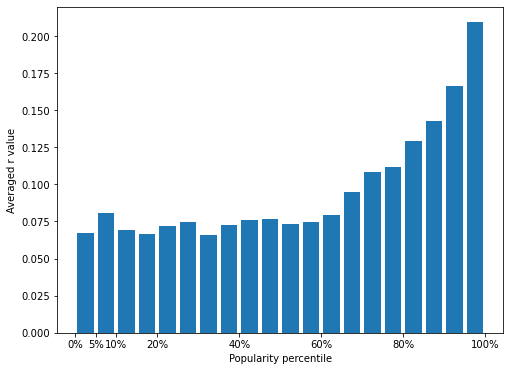

In [8]:
pd1 = df_pearsonr.sort_values(by=['daily views'])
edges = np.linspace(0, len(pd1.index), num=21)
pd1_bins = [pd1.iloc[int(edges[x]):int(edges[x+1]),:]["r"] for x in range(len(edges)-1)]

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1,1,1)
ax.bar(list(range(20)), [np.mean(x) for x in pd1_bins])
ax.set_xticks(np.array([0, 1, 2, 4, 8, 12, 16, 20])-0.5)
ax.set_xticklabels(["0%", "5%", "10%", "20%", "40%", "60%", "80%", "100%"])
ax.set_xlabel("Popularity percentile")
ax.set_ylabel("Averaged r value")
pass

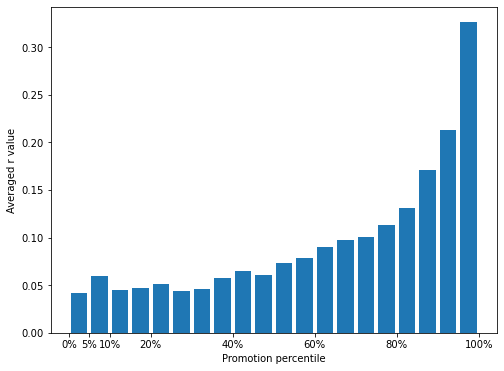

In [9]:
pd2 = df_pearsonr.sort_values(by=['daily tweets'])
edges = np.linspace(0, len(pd2.index), num=21)
pd2_bins = [pd2.iloc[int(edges[x]):int(edges[x+1]),:]["r"] for x in range(len(edges)-1)]

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1,1,1)
ax.bar(list(range(20)), [np.mean(x) for x in pd2_bins])
ax.set_xticks(np.array([0, 1, 2, 4, 8, 12, 16, 20])-0.5)
ax.set_xticklabels(["0%", "5%", "10%", "20%", "40%", "60%", "80%", "100%"])
ax.set_xlabel("Promotion percentile")
ax.set_ylabel("Averaged r value")
pass